# Example of extracting table data from Microsoft DOCX documents

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
#%%bash
#if python -c 'import google.colab' &> /dev/null; then
#    echo "Run on Google Colab!"
#    echo "Install Open JDK"
#    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
#    java -version
#fi

In [3]:
import os
import sys

#if 'google.colab' in sys.modules:
#  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#%pip install --upgrade spark-ocr==4.0.0+spark32 --user --extra-index-url https://pypi.johnsnowlabs.com/$secret --upgrade
#!pip install --upgrade spark-ocr==4.0.0+spark32 --user --extra-index-url https://pypi.johnsnowlabs.com/$secret --upgrade


In [5]:
# or install from local path
# %pip install ../../python/dist/spark-ocr-1.10.0.spark24.tar.gz

## Initialization of spark session

In [6]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark.conf.set("spark.sql.optimizer.expression.nestedPruning.enabled", False)
spark.conf.set("spark.sql.optimizer.nestedSchemaPruning.enabled", False)
spark

Spark version: 3.1.3
Spark NLP version: 4.0.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.0.1



## Import OCR transformers

In [7]:
from sparkocr.transformers import *
from sparkocr.utils import display_image
from pyspark.sql.functions import collect_list,col

## Read DOCX document as binary file

In [8]:
import pkg_resources
doc_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/docs/doc2.docx')
doc_example_df = spark.read.format("binaryFile").load(doc_example).cache()

## Preview document using `DocToPdf` and `PdfToImage` transformers


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


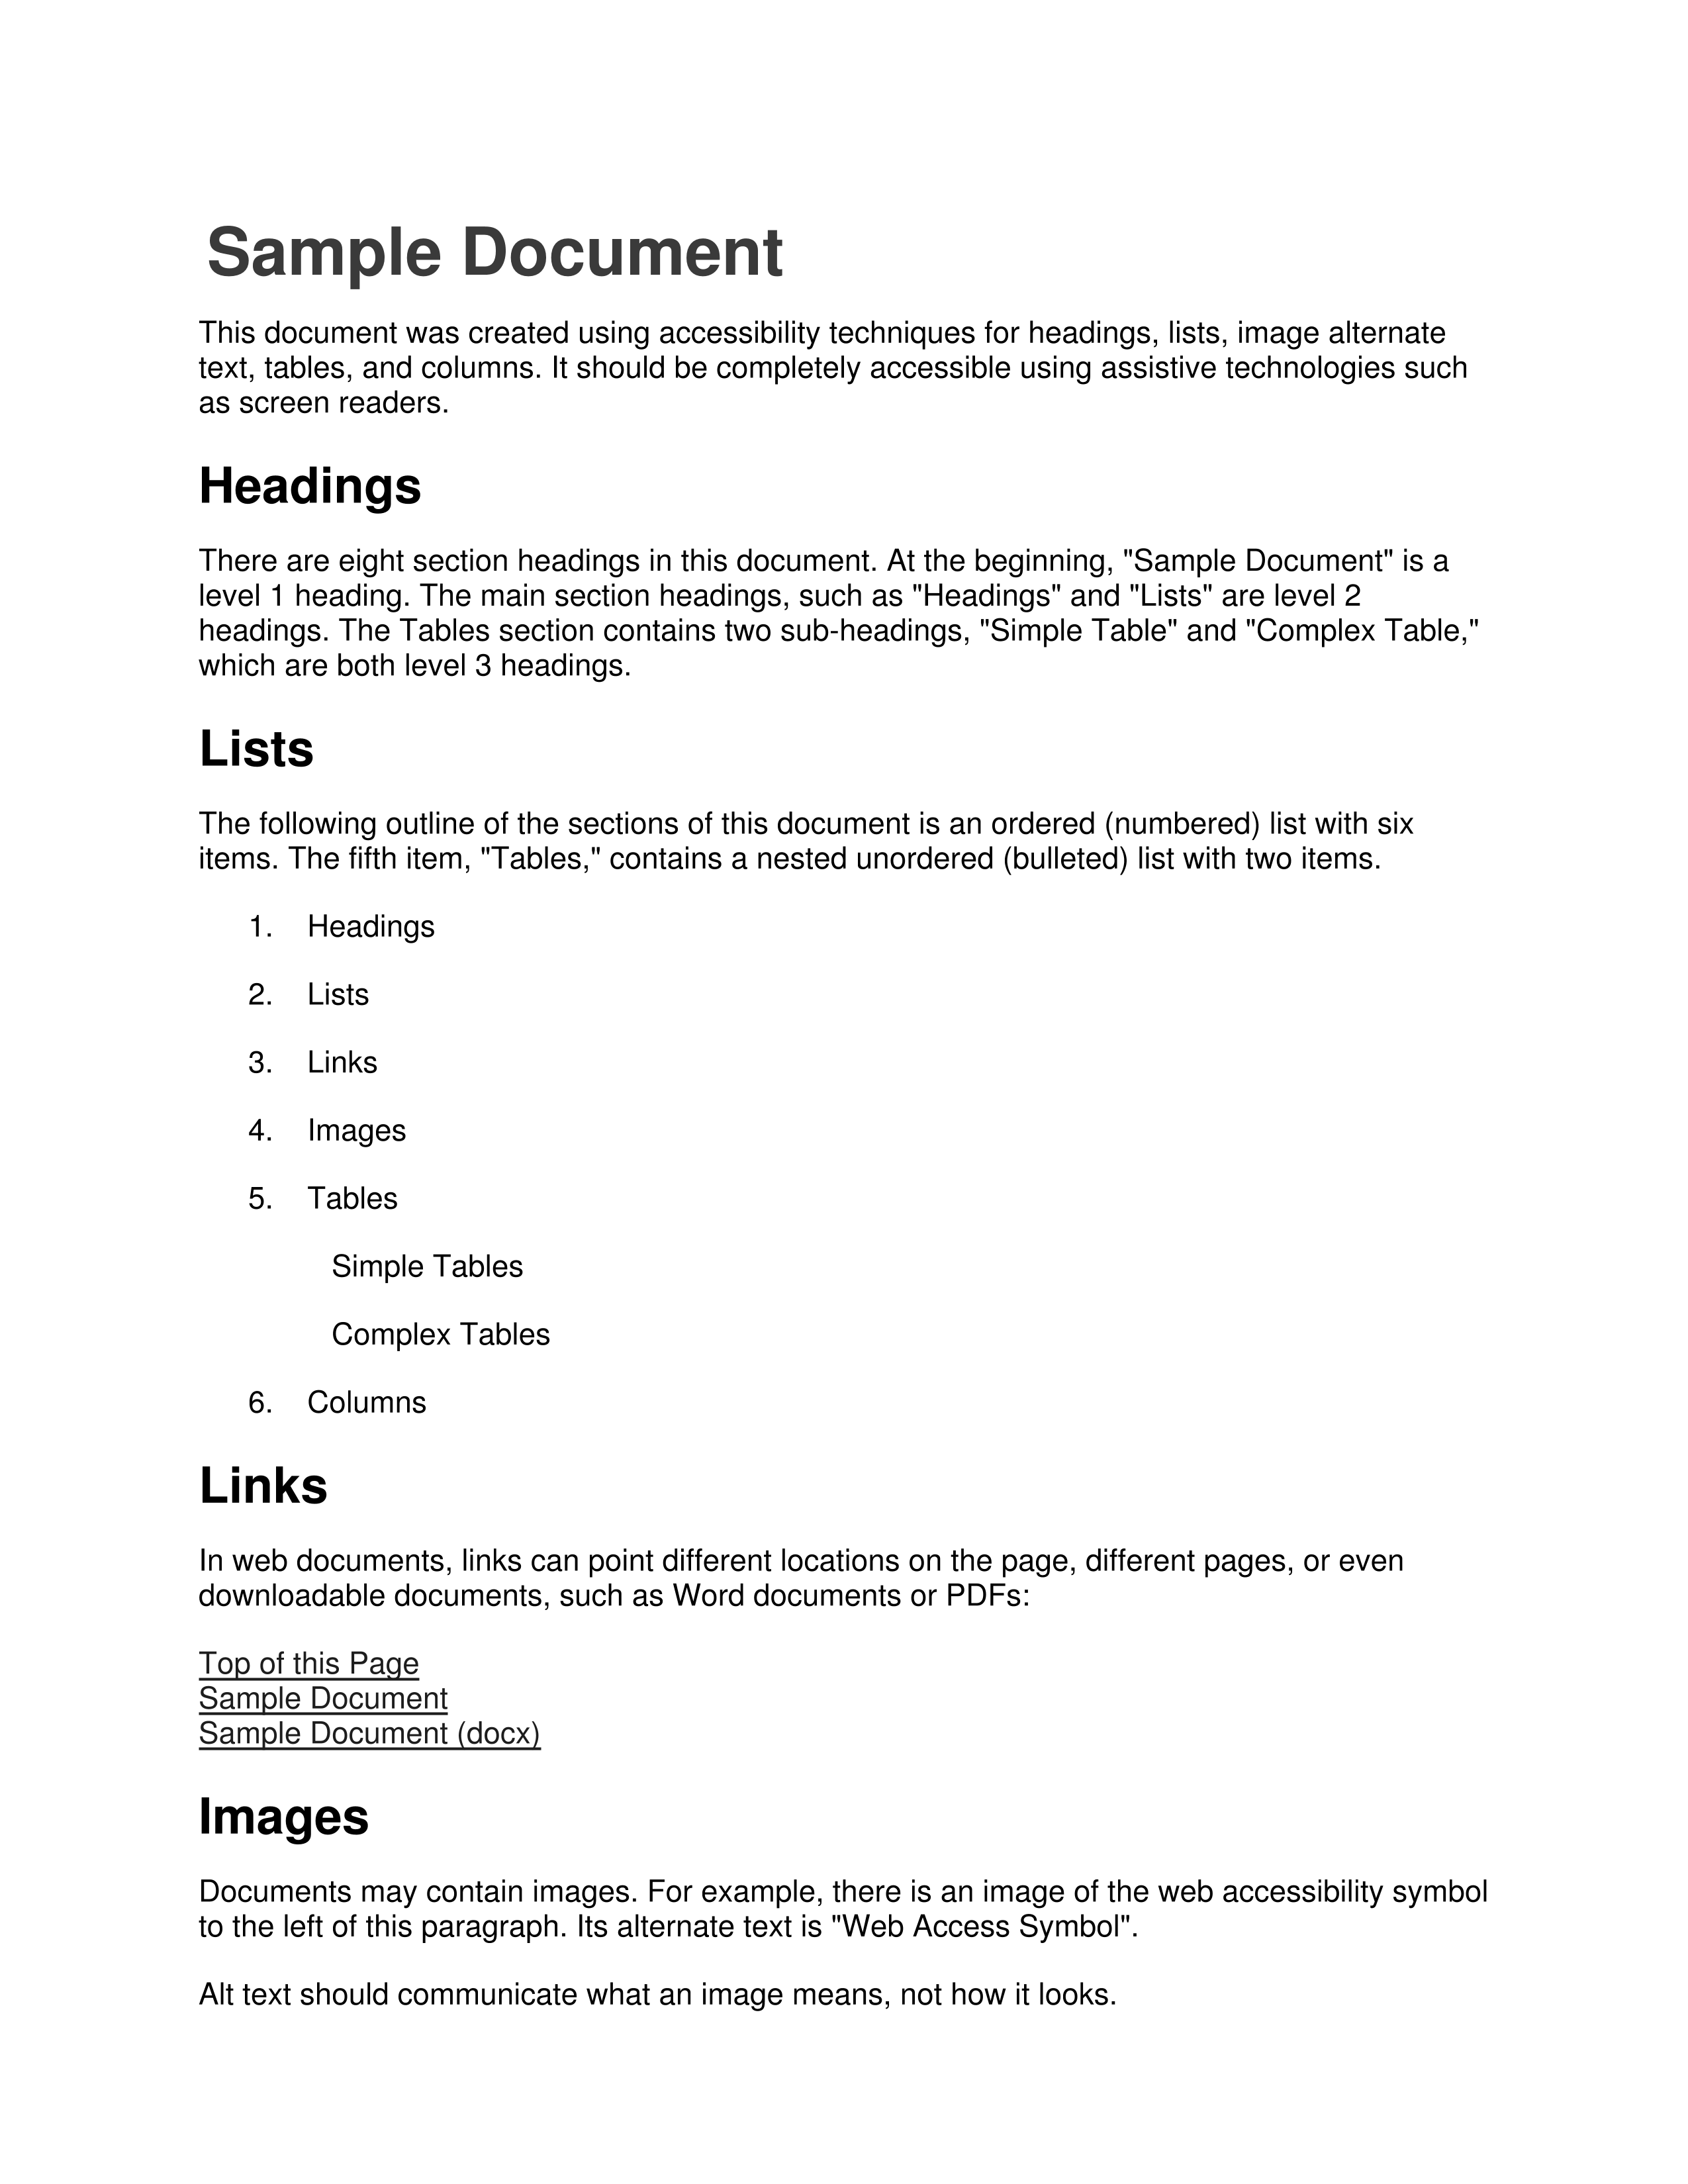


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


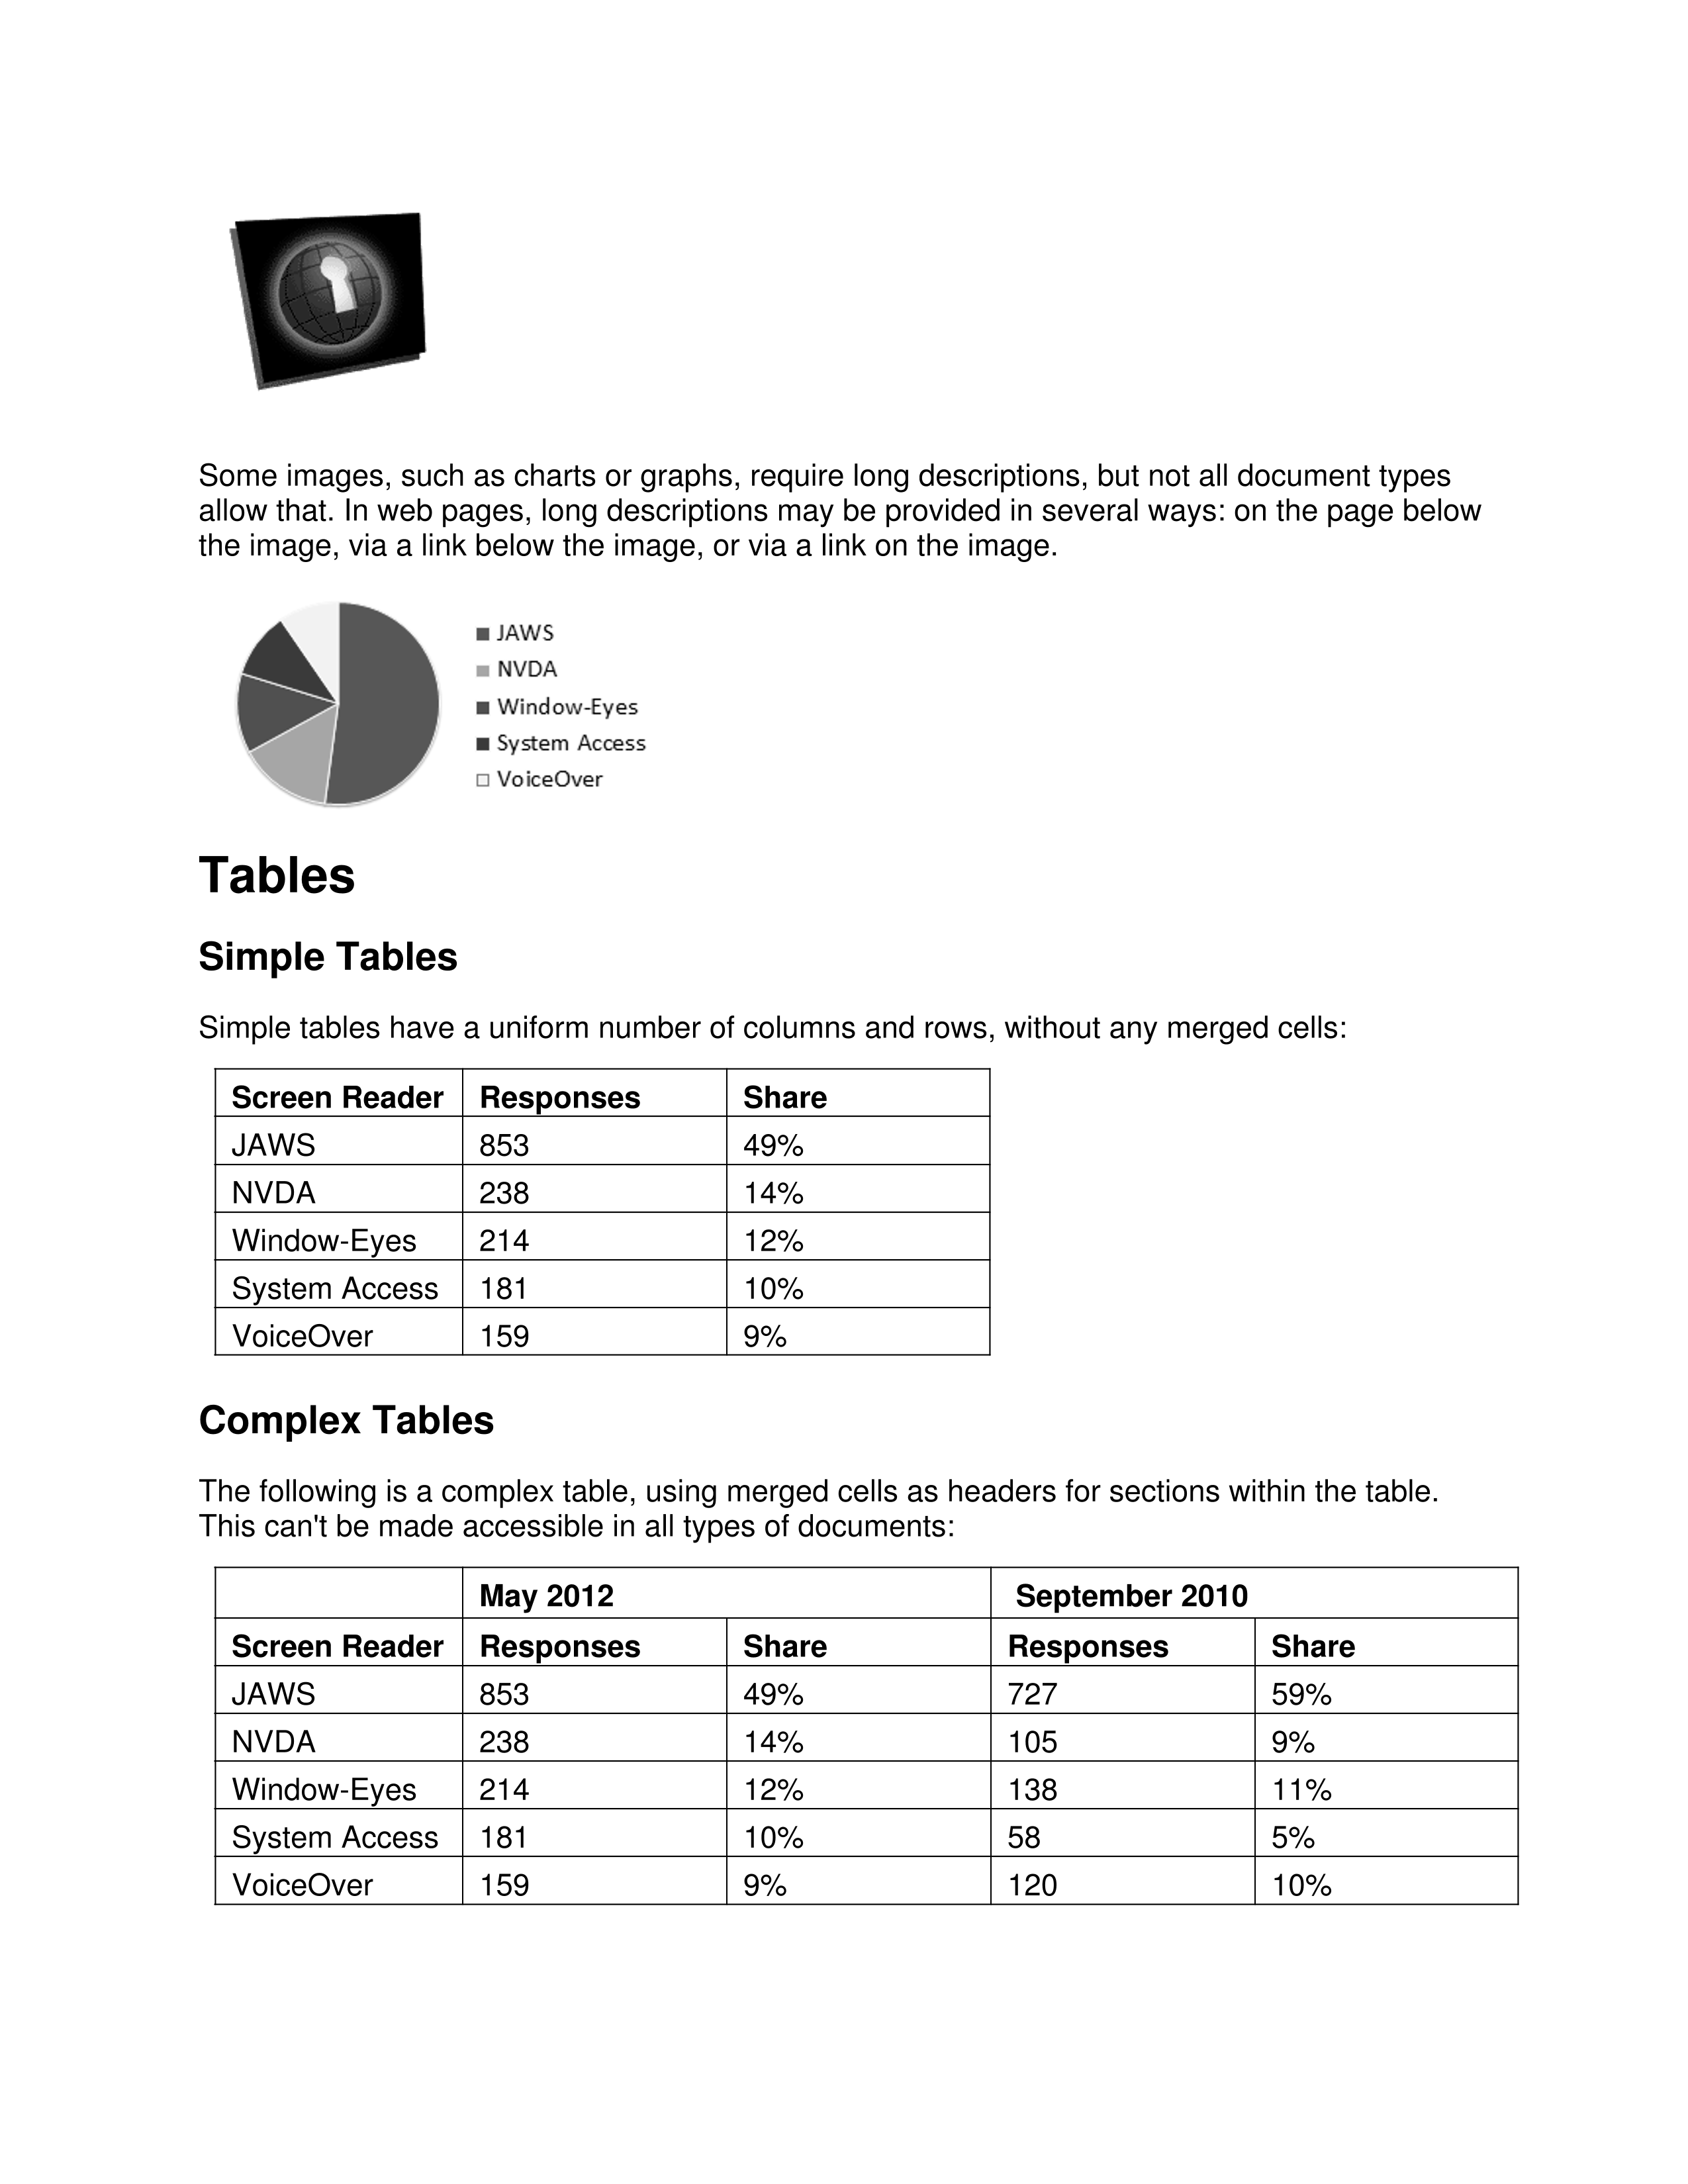


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


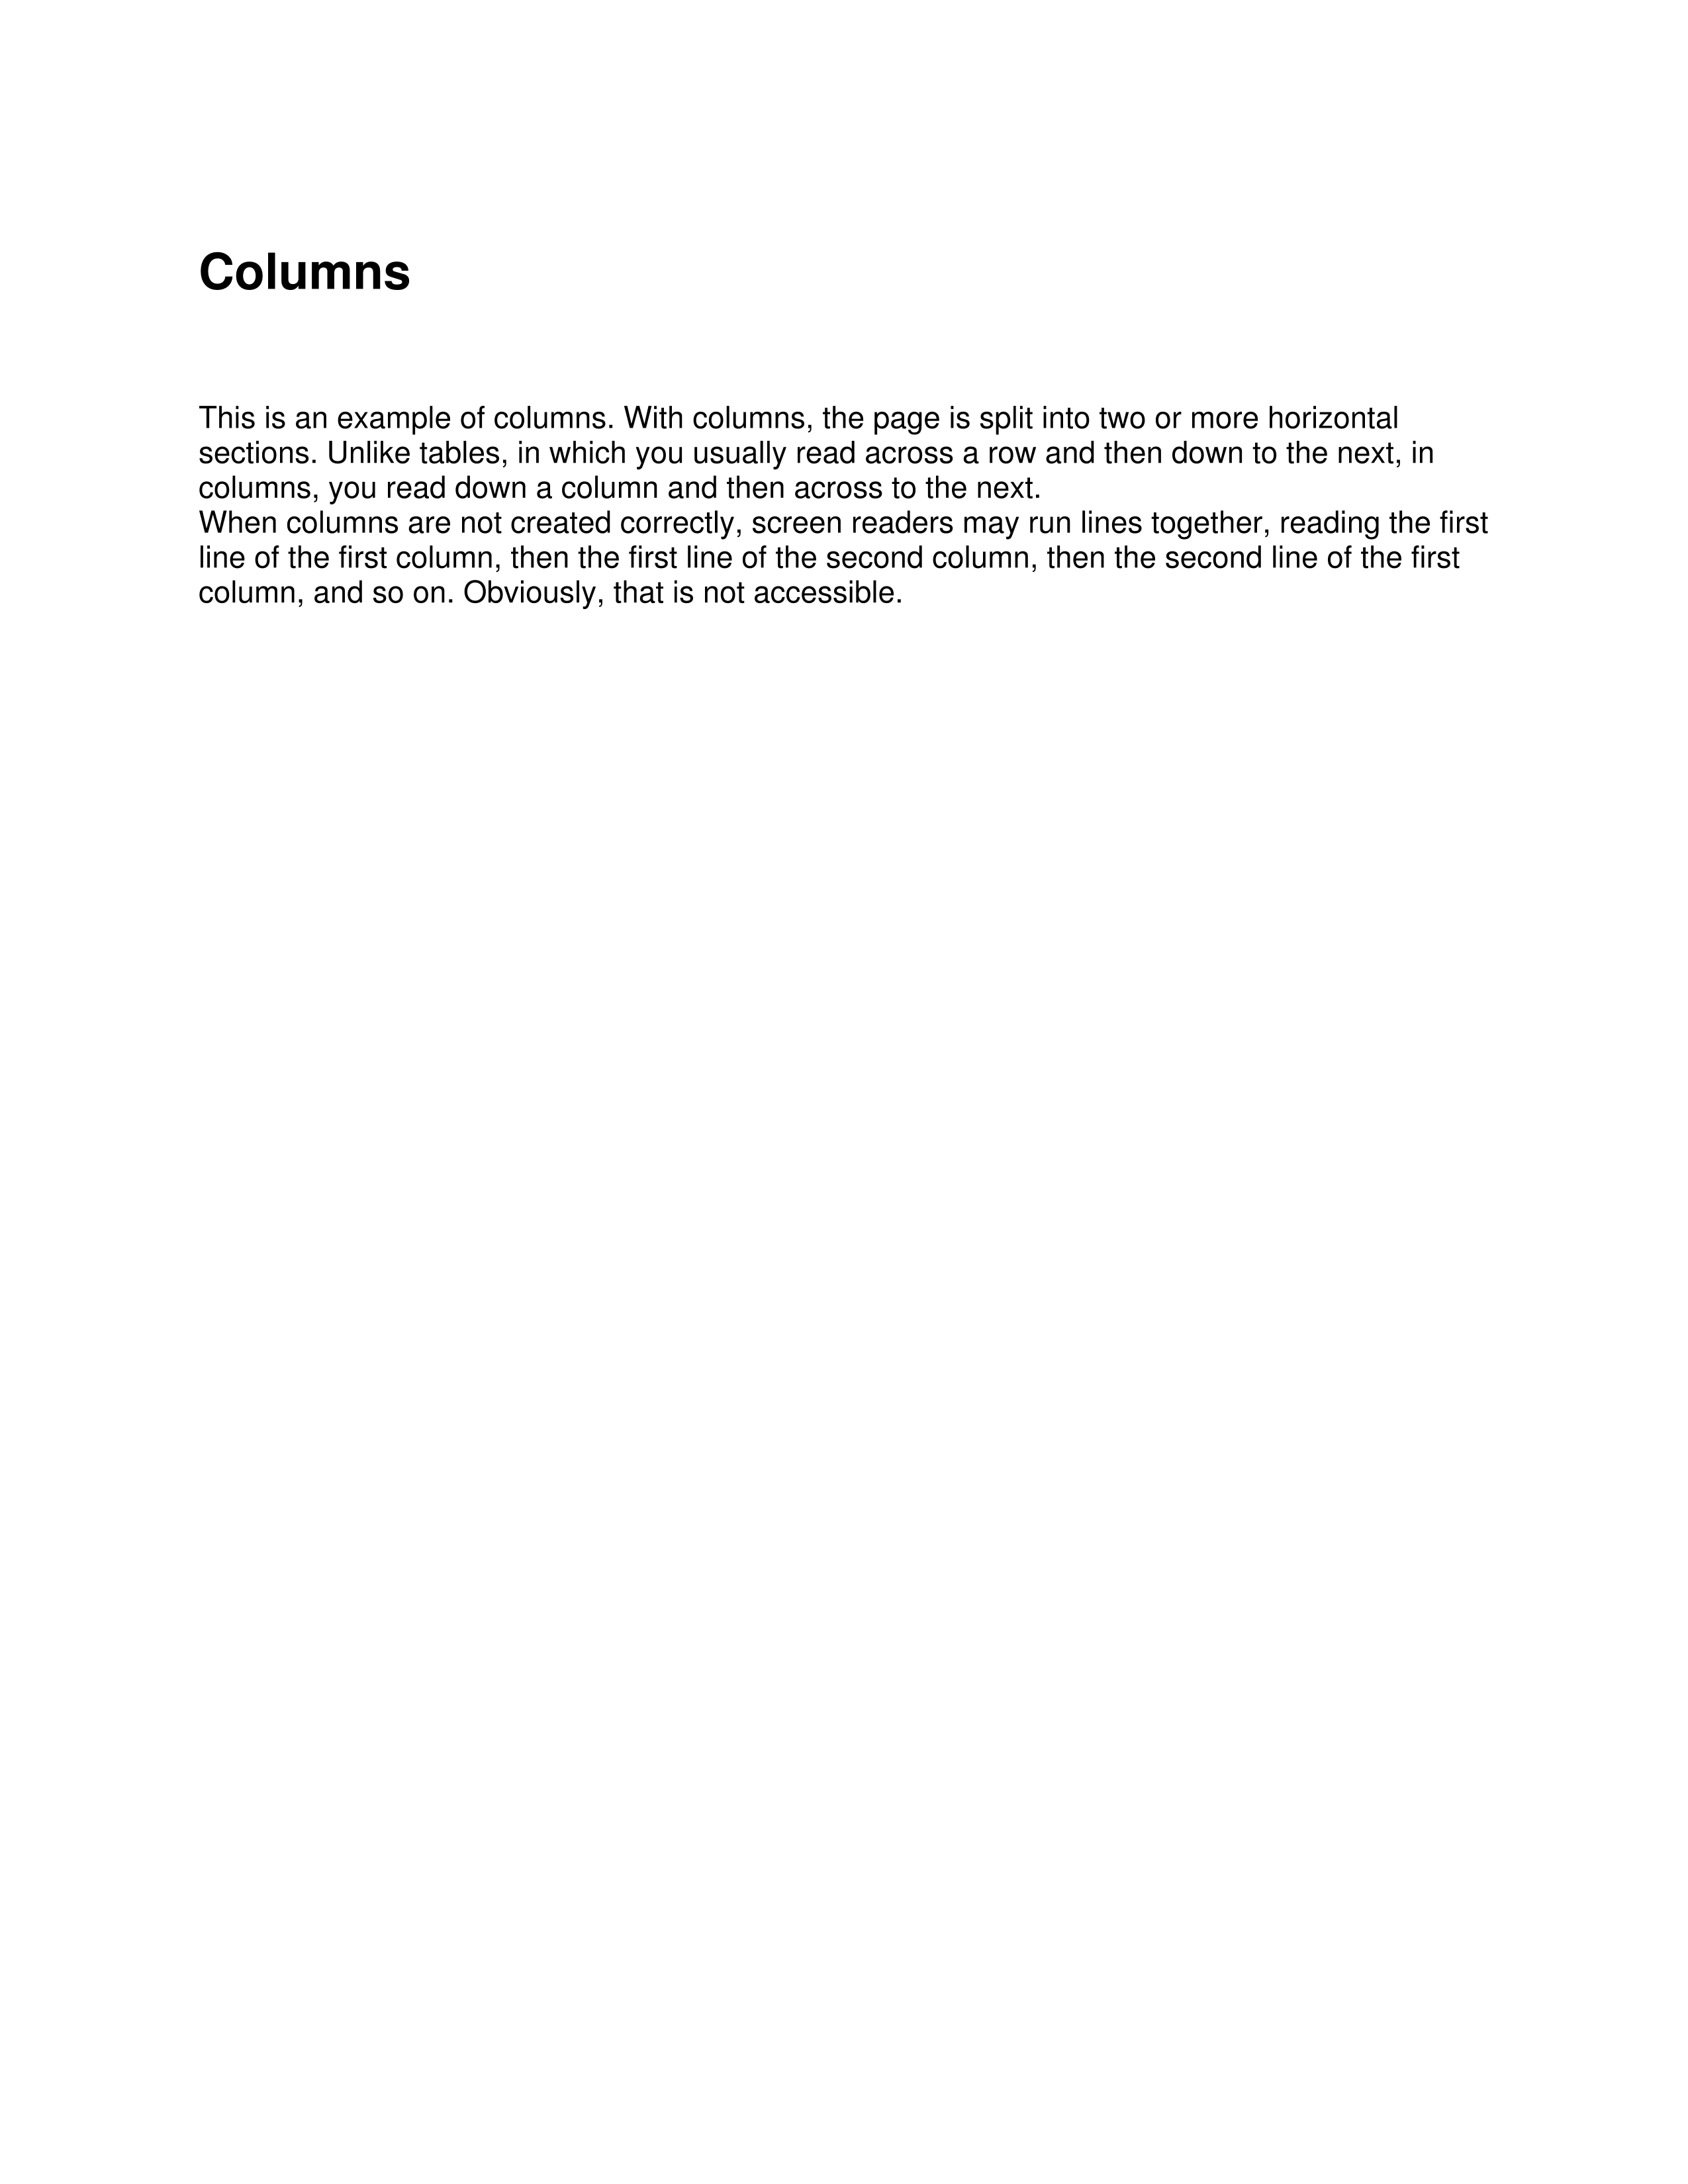

In [9]:
image_df = PdfToImage().transform(DocToPdf().setOutputCol("content").transform(doc_example_df))
for r in image_df.select("image").collect():
    display_image(r.image)

## Extract text using `DocToText` transformer

In [10]:
doc_to_table = DocToTextTable()
doc_to_table.setInputCol("content")
doc_to_table.setOutputCol("tables")

result = doc_to_table.transform(doc_example_df)

## Display result DataFrame

In [11]:
result.show()

+--------------------+--------------------+------+--------------------+---------+
|                path|    modificationTime|length|              tables|exception|
+--------------------+--------------------+------+--------------------+---------+
|file:/home/jose/....|2022-08-04 22:56:...| 33260|{{0, 0, 0.0, 0.0,...|     null|
|file:/home/jose/....|2022-08-04 22:56:...| 33260|{{1, 0, 0.0, 0.0,...|     null|
+--------------------+--------------------+------+--------------------+---------+



## Display extracted text of cell from second row and first column

In [12]:
result.select("tables.chunks").printSchema()

root
 |-- chunks: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- chunkText: string (nullable = false)
 |    |    |    |-- x: float (nullable = false)
 |    |    |    |-- y: float (nullable = false)
 |    |    |    |-- width: float (nullable = false)
 |    |    |    |-- height: float (nullable = false)



In [13]:
r = result.select(result["tables.chunks"].getItem(1).alias("my_arrays"))

r.select(r["my_arrays"].chunkText[0]).show(truncate=False)

+----------------------+
|my_arrays.chunkText[0]|
+----------------------+
|JAWS                  |
|Screen Reader         |
+----------------------+



In [14]:
result.select(result["tables.chunks"].getItem(1)).printSchema()

root
 |-- tables.chunks AS `chunks`[1]: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- chunkText: string (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)



In [15]:
result.select(result["tables.chunks"].getItem(1)['chunkText'][0]).show()

+-------------------------------------------+
|tables.chunks AS chunks#377[1].chunkText[0]|
+-------------------------------------------+
|                                       JAWS|
|                              Screen Reader|
+-------------------------------------------+



## Display extracted data in JSON format

In [16]:
import json
df_json = result.select("tables").toJSON()
for row in df_json.collect():
    print(json.dumps(json.loads(row), indent=4))

{
    "tables": {
        "area": {
            "index": 0,
            "page": 0,
            "x": 0.0,
            "y": 0.0,
            "width": 0.0,
            "height": 0.0,
            "score": 0.0,
            "label": "0",
            "angle": 0.0
        },
        "chunks": [
            [
                {
                    "chunkText": "Screen Reader",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 90.0,
                    "height": 0.0
                },
                {
                    "chunkText": "Responses",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                },
                {
                    "chunkText": "Share",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                }
            ],
            [
                {
              

In [17]:
spark.stop()